In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import math
import os
import sys
import warnings
import argparse
import numpy as np
import yaml
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import Lock
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool, cpu_count

import time
import threading
import random 
from sklearn import mixture
from sklearn.utils import shuffle
from skimage import measure

from glob import glob
from tqdm import tqdm
import math

sys.path.append("/home/shiyi/gpu/gpu/")
sys.path.append("/home/shiyi/colposcopy/colposcopy/util")
img_dir_origin = "/data/colposcopy/colposcopy/"
img_dir_modified = "/data/colposcopy/colposcopy_1/"
target_dir = ''
from gpu_allocation import set_gpu

In [8]:
import csv
def bbox_file_reader(file_name):
    csv_path = os.path.join(img_dir_origin,file_name)
    f = open(csv_path)
    f_csv = csv.reader(f)
    pic_dict = {}
    for row, in f_csv:
        type_cur = row.split('\\')[0]
        name_cur = row.split('\\')[1].split()[0]
        num_cur =  int(row.split()[1])
        boxes = row.split()[2:6]
        path = os.path.join(img_dir_origin,'train','_'.join(file_name.split('_')[:2]),name_cur)
        #print([path,boxes])
        label = 0
        if os.path.exists(path):
            label = 1
            pic_dict[path] = boxes
            #print([path,boxes])
    return pic_dict
    
bbox_1 = bbox_file_reader("Type_1_bbox.tsv")
bbox_2 = bbox_file_reader("Type_2_bbox.tsv")
bbox_3 = bbox_file_reader("Type_3_bbox.tsv")

dictMerged = dict( bbox_1, **bbox_2 )
dictPath = dict( dictMerged, **bbox_3 )
print (len(dictPath))
print (dictPath.items()[0])
img_paths = dictPath.keys()

1466
(u'/data/colposcopy/colposcopy/train/Type_1/1239.jpg', ['1178', '711', '1074', '1220'])


In [13]:
def remove_sr(img): 
    r_c = img[:,:,2]
    g_c = img[:,:,1]
    b_c = img[:,:,0]
    _,r_thres = cv2.threshold(r_c, 190, 255, cv2.THRESH_BINARY)
    _,g_thres = cv2.threshold(g_c, 180, 255, cv2.THRESH_BINARY)
    _,b_thres = cv2.threshold(b_c, 210, 255, cv2.THRESH_BINARY)
    mixed = r_thres & b_thres & g_thres 
    kernel_dilate = np.ones((18, 18), np.uint8)
    mask = cv2.dilate(mixed,kernel_dilate)
    dst = cv2.inpaint(img,mixed,14,cv2.INPAINT_TELEA)
    return dst

def cvt(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

def plot(img,coords):
    colors = plt.cm.hsv(np.linspace(0, 1, 100)).tolist()
    color = colors[random.randint(0,99)]
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # plot the image for matplotlib
    currentAxis = plt.gca()
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=1))
    #currentAxis.text(pt[0], pt[1], label, bbox={'facecolor':color, 'alpha':0.5})
    
def crop_img(file_name,bboxes): 
    img = cv2.imread(file_name)
    label = file_name.split('/')[-2]
    #plt.figure(figsize=(10,10))
    box = bboxes
    pt = [int(i) for i in box]
    coords = (pt[0], pt[1]), pt[2],pt[3]
    pt_x_min = pt[0]
    pt_x_max = pt[0]+pt[2]-1
    pt_y_min = pt[1]
    pt_y_max = pt[1]+pt[3]-1
    return img[pt_y_min:pt_y_max,pt_x_min:pt_x_max],coords



In [3]:
from multiprocessing import Lock
from multiprocessing.dummy import Pool as ThreadPool 
import time
import threading
from tqdm import tqdm
import os
import numpy as np

num_thread = 30
num_images = len(img_paths)
print (num_images)
pool = ThreadPool(num_thread)

def preprocess_cervical_1(path):
    global progress,lock
    #print("Thread {}, image {}|{}, name: {}".format(thread_id, index-index_slice[0], len(index_slice) ,img_paths[index]))
    img_name_target = os.path.join(img_dir_modified + '/'.join(path.split('/')[4:]))
    box = dictPath[path]
    print (path,box)
    try:
        img_crop,_ = crop_img(path,box)
        dst = remove_sr(img_crop)
        cv2.imwrite(img_name_target,dst)
    except cv2.error:
        print ("skipped,continue")

print ('Parent process %s.' % os.getpid())

start_time = time.time()
pool.map(preprocess_cervical_1,img_paths)
pool.close()
pool.join()
end_time = time.time()

print ("done,it takes:",end_time-start_time)


1466
Parent process 20618.
/data/colposcopy/colposcopy/train/Type_1/1239.jpg/data/colposcopy/colposcopy/train/Type_3/187.jpg/data/colposcopy/colposcopy/train/Type_1/1024.jpg ['214', '1551', '1142', '642']
/data/colposcopy/colposcopy/train/Type_2/52.jpg  ['780', '834', '572', '736']
/data/colposcopy/colposcopy/train/Type_3/16.jpg ['1178', '711', '1074', '1220']
/data/colposcopy/colposcopy/train/Type_3/654.jpg ['706', '1340', '1258', '1845']
/data/colposcopy/colposcopy/train/Type_3/1306.jpg ['1174', '1369', '496', '556']
/data/colposcopy/colposcopy/train/Type_1/102.jpg ['722', '1486', '546', '495']
 ['1002', '2017', '520', '1520']
['1016', '1480', '602', '856']
/data/colposcopy/colposcopy/train/Type_1/1079.jpg ['348', '751', '1632', '1285']
/data/colposcopy/colposcopy/train/Type_3/1335.jpg ['228', '860', '1472', '1497']
/data/colposcopy/colposcopy/train/Type_3/823.jpg ['1786', '158', '1512', '1853']
/data/colposcopy/colposcopy/train/Type_2/40.jpg ['998', '899', '558', '467']
/data/colpos

NameError: global name 'crop_img' is not defined

/data/colposcopy/colposcopy_1/train/Type_2/1104.jpg
(1032, 811, 3)


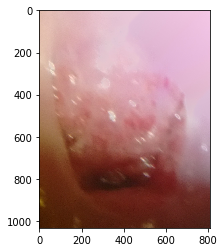

In [14]:
pic = img_paths[12]

print(img_dir_modified + '/'.join(pic.split('/')[4:]))
pic_tar = img_dir_modified + '/'.join(pic.split('/')[4:])
img = cv2.imread(pic_tar)

plt.imshow(cvt(img))
print (img.shape)